# Getting Started

To get the best result, you can follow my preivous dicussion about [How to win object detection competetion](https://www.kaggle.com/c/global-wheat-detection/discussion/232550#1273363) where i got a gold medal.

And [This notebook](https://www.kaggle.com/espsiyam/yolov5-ensemble-tta-transfer-learning-hpt)

In [1]:
# Importing Required packages
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
clear_output()

In [2]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [3]:
# Cloning the repo and installing requiements
!git clone https://github.com/ultralytics/yolov5.git
!mv ./yolov5/* ./
!pip install -r requirements.txt
clear_output()

# Preparing the dataset

In [4]:
# Copying the dataset to working directory
!mkdir Dataset
!cp ../input/covid19-detection-for-yolov5-siimfisabiorsna/Covid19 -r ./Dataset
clear_output()

In [5]:
len(os.listdir('./Dataset/Covid19/images'))

4294

In [6]:
%%writetemplate ./split_dataset.py
from utils.datasets import * 
autosplit('./Dataset/Covid19', weights=(0.8, 0.2, 0.0))

Sptting the dataset for training and validation using datasets from yolov5 repo

In [7]:
!python split_dataset.py

Autosplitting images from Dataset/Covid19
100%|████████████████████████████████████| 4294/4294 [00:00<00:00, 27523.93it/s]


In [8]:
os.listdir('./Dataset/Covid19')

['labels', 'images', 'autosplit_val.txt', 'autosplit_train.txt']

In [9]:
!mkdir DataFile

Defining the dataset

In [10]:
%%writetemplate ./DataFile/data.yaml

train: ./Dataset/Covid19/autosplit_train.txt
val: ./Dataset/Covid19/autosplit_val.txt

nc: 4
names: ['Negative for Pneumonia', 'Typical Appearance',
        'Indeterminate Appearance', 'Atypical Appearance']

# Model Declaration

you can find all the models [here](https://github.com/ultralytics/yolov5/tree/master/models) and cutomize the classes accordingly.

In [11]:
%%writetemplate ./models/custom_yolov5x.yaml


# parameters
nc: 4  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [12]:
# I've used wandb before, I don't want it now. So might not need to run this cell
!wandb off

W&B offline, running your script from this directory will only write metadata locally.


# Training the model

In [13]:
%%time

!python train.py --img-size 602 --batch 10 --epochs 40 --data './DataFile/data.yaml' --cfg ./models/custom_yolov5x.yaml --weights yolov5x.pt --name experiment2  --cache

github: skipping check (not a git repository)
2021-05-23 00:00:36.396370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-23 00:00:41.121021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-23 00:00:41.123336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.












































































































































wandb: Waiting for W&B process to finish, PID 150
wandb: Program ended successfully.
wandb: Find user logs for this run at: /kaggle/working/wandb/offline-run-20210523_000040-179i08ek/logs/debug.log
wandb: Find internal logs for this run at: /kaggle

In [14]:
%load_ext tensorboard
%tensorboard --logdir runs

# Analyze the result

In [15]:
os.listdir('./runs/train/experiment2/')

['events.out.tfevents.1621728040.ce0f4901261d.137.0',
 'train_batch2.jpg',
 'train_batch0.jpg',
 'confusion_matrix.png',
 'opt.yaml',
 'train_batch1.jpg',
 'P_curve.png',
 'hyp.yaml',
 'PR_curve.png',
 'labels.jpg',
 'test_batch2_pred.jpg',
 'R_curve.png',
 'results.txt',
 'labels_correlogram.jpg',
 'test_batch2_labels.jpg',
 'F1_curve.png',
 'test_batch0_labels.jpg',
 'test_batch1_labels.jpg',
 'test_batch0_pred.jpg',
 'weights',
 'test_batch1_pred.jpg',
 'results.png']

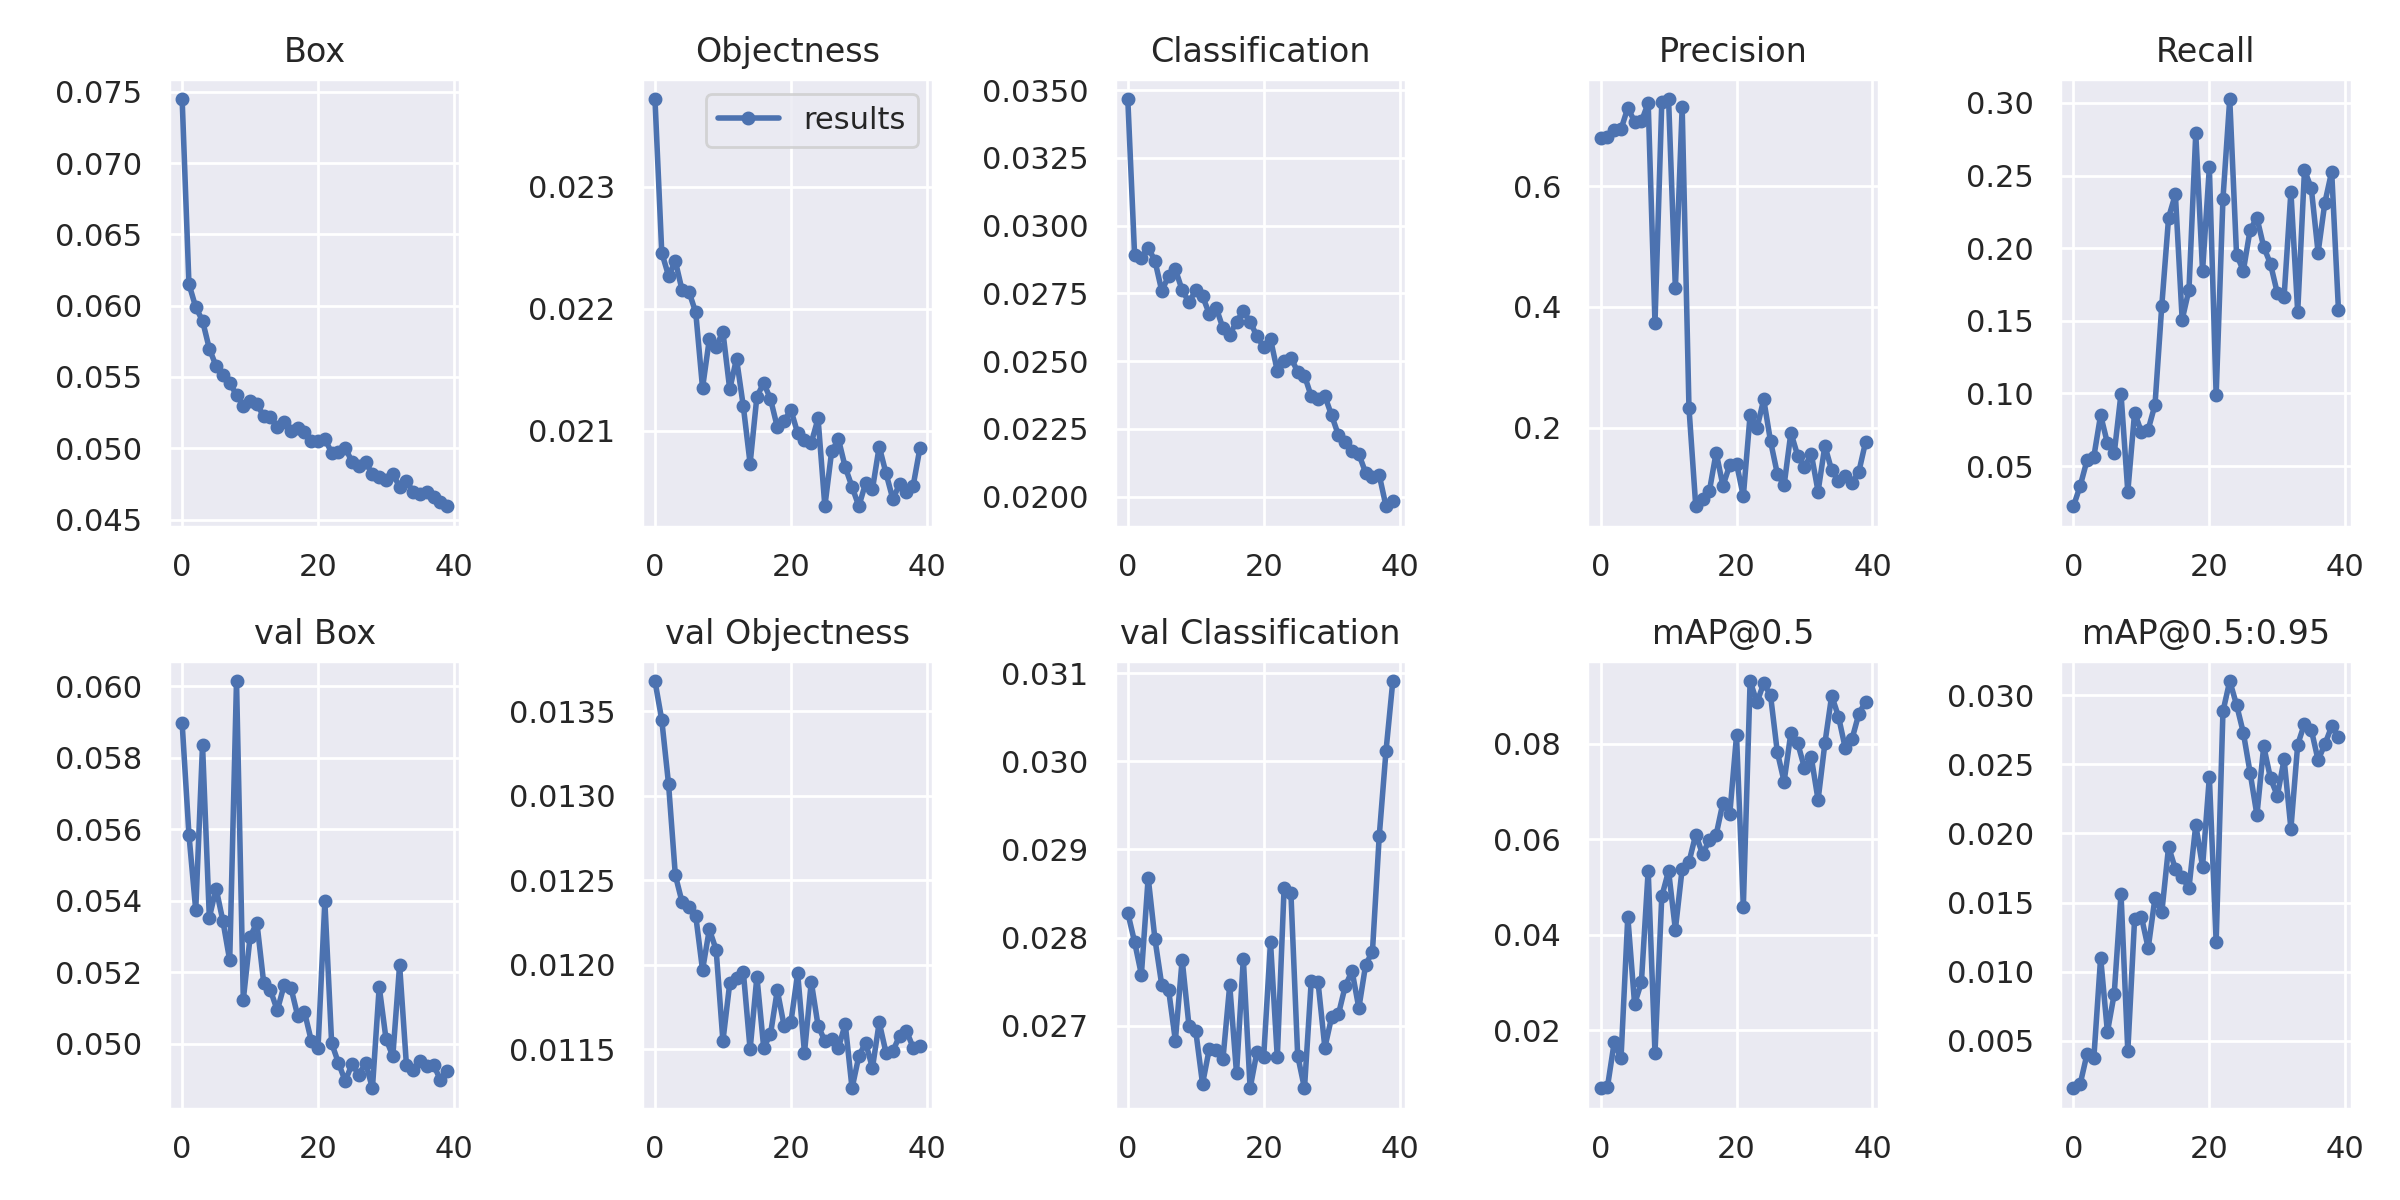

In [16]:
Image('./runs/train/experiment2/results.png')

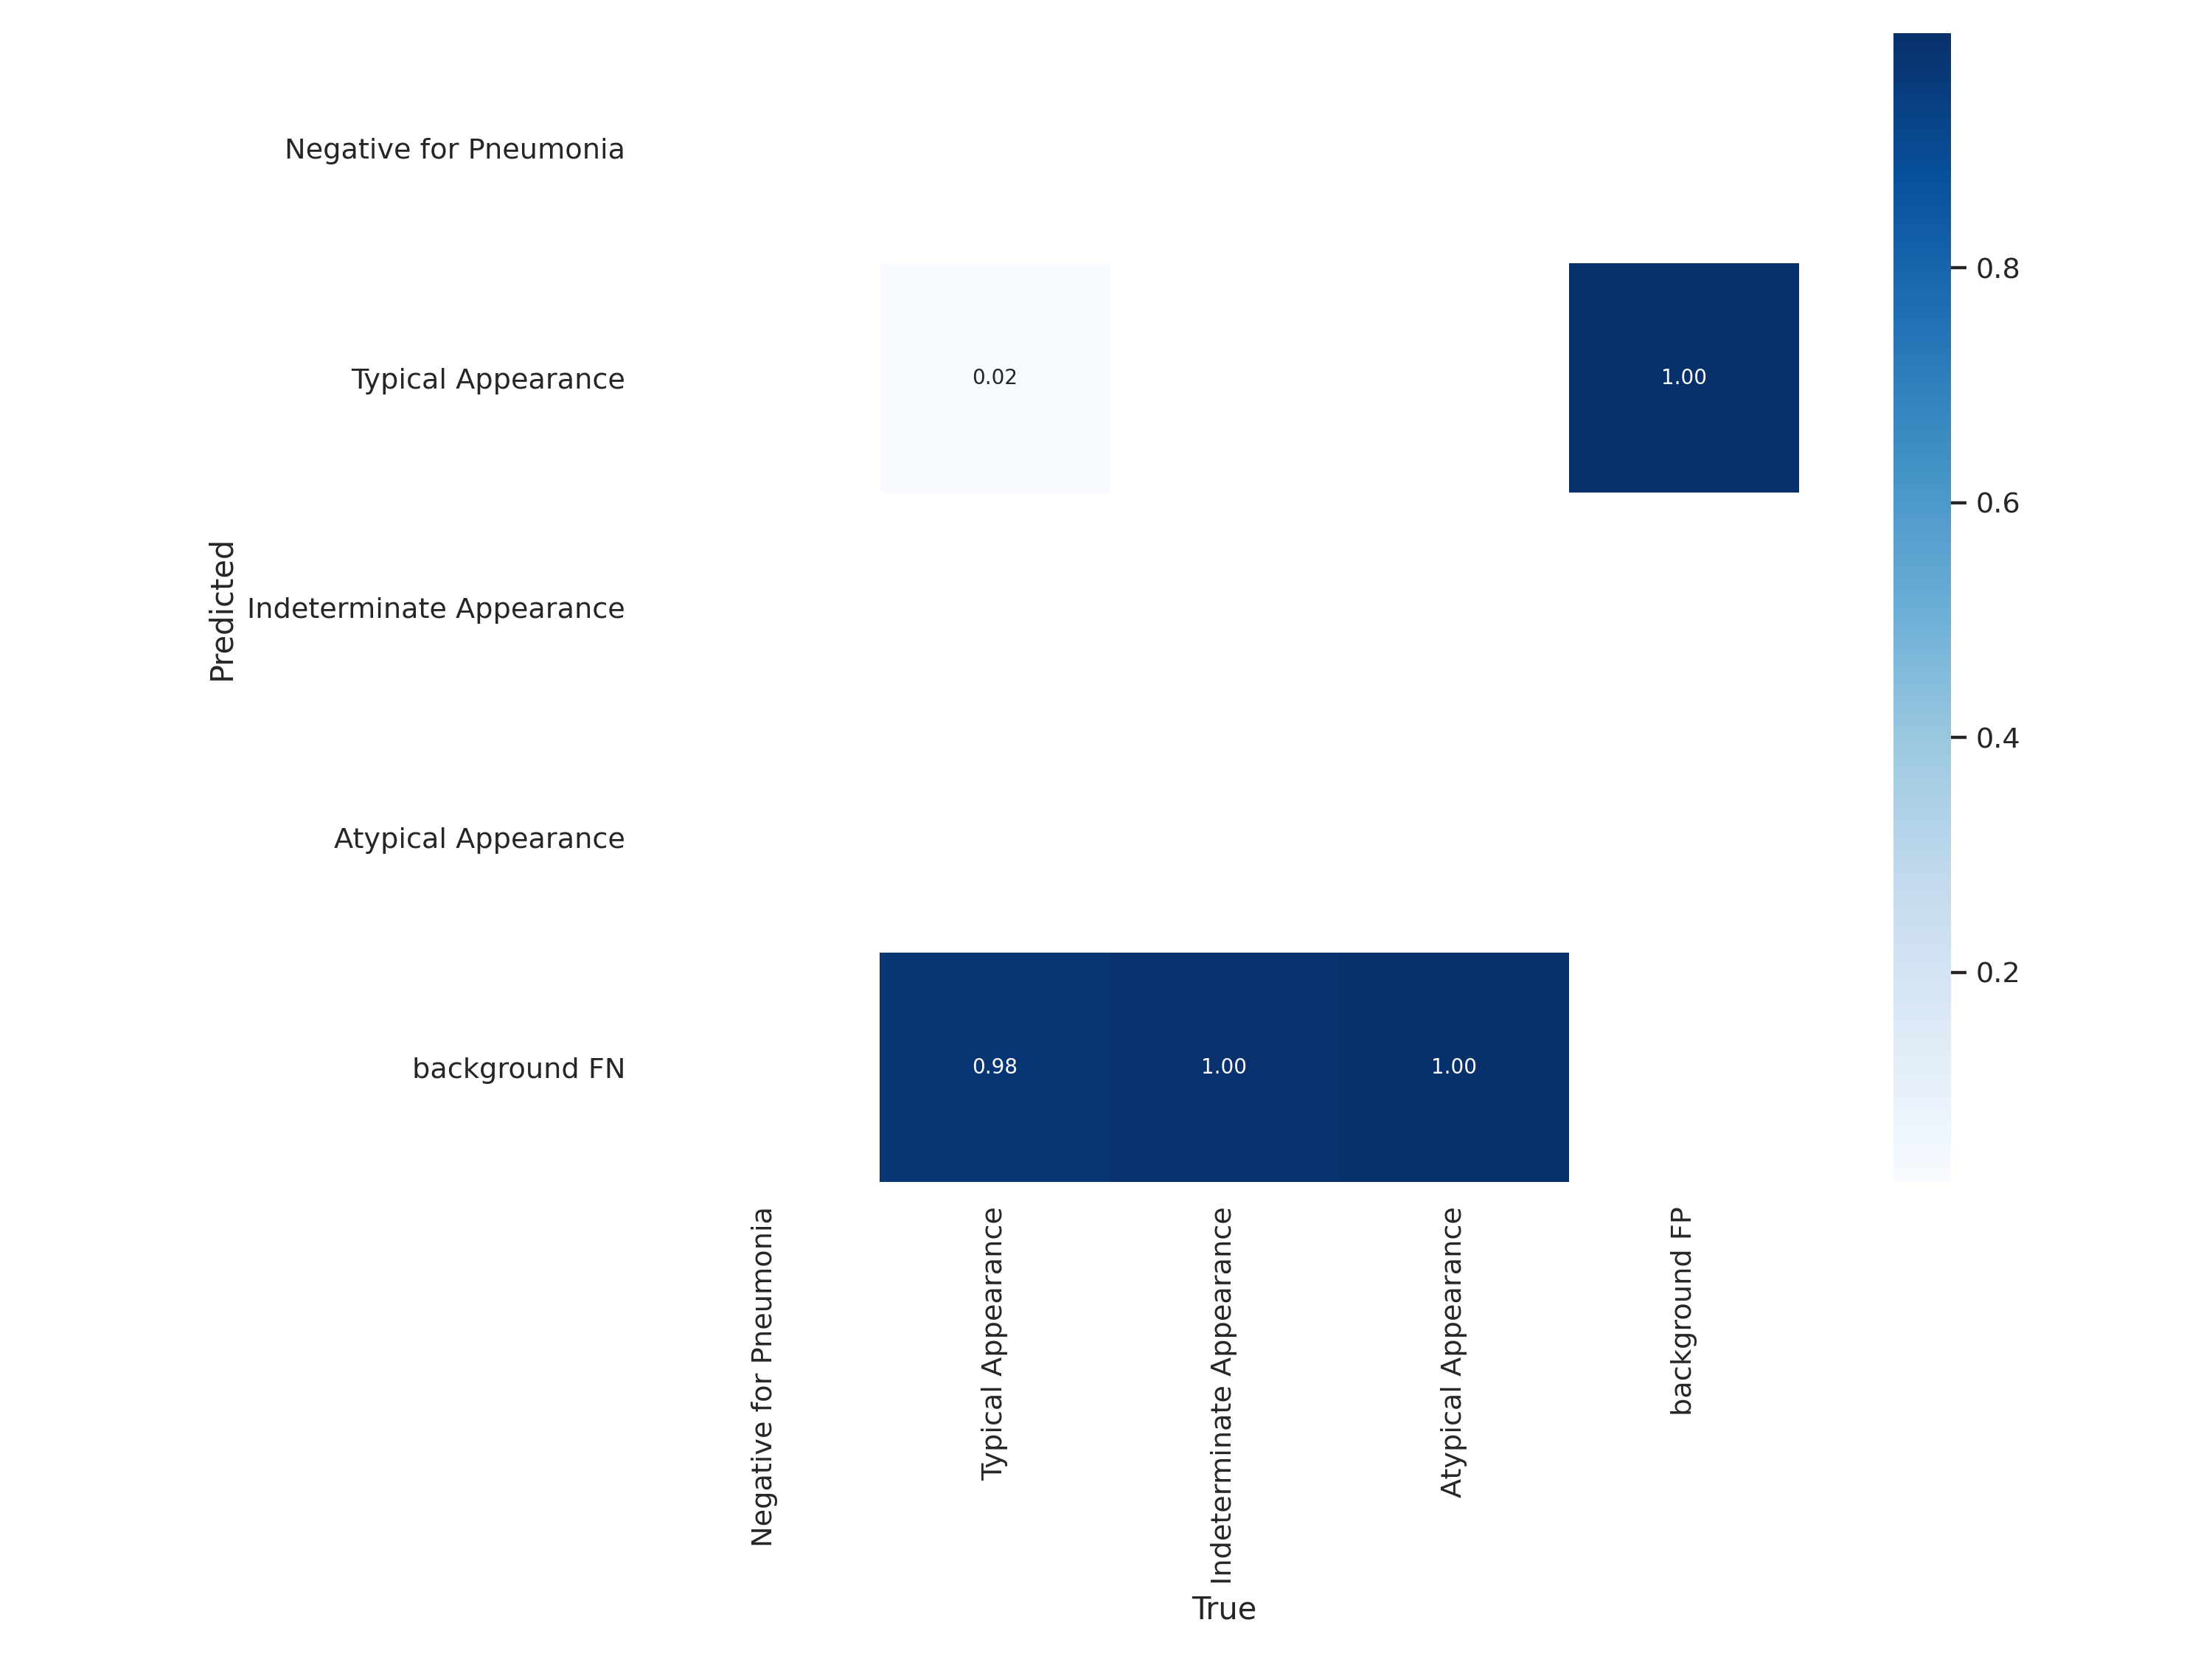

In [17]:
Image('./runs/train/experiment2/confusion_matrix.png',width=400)

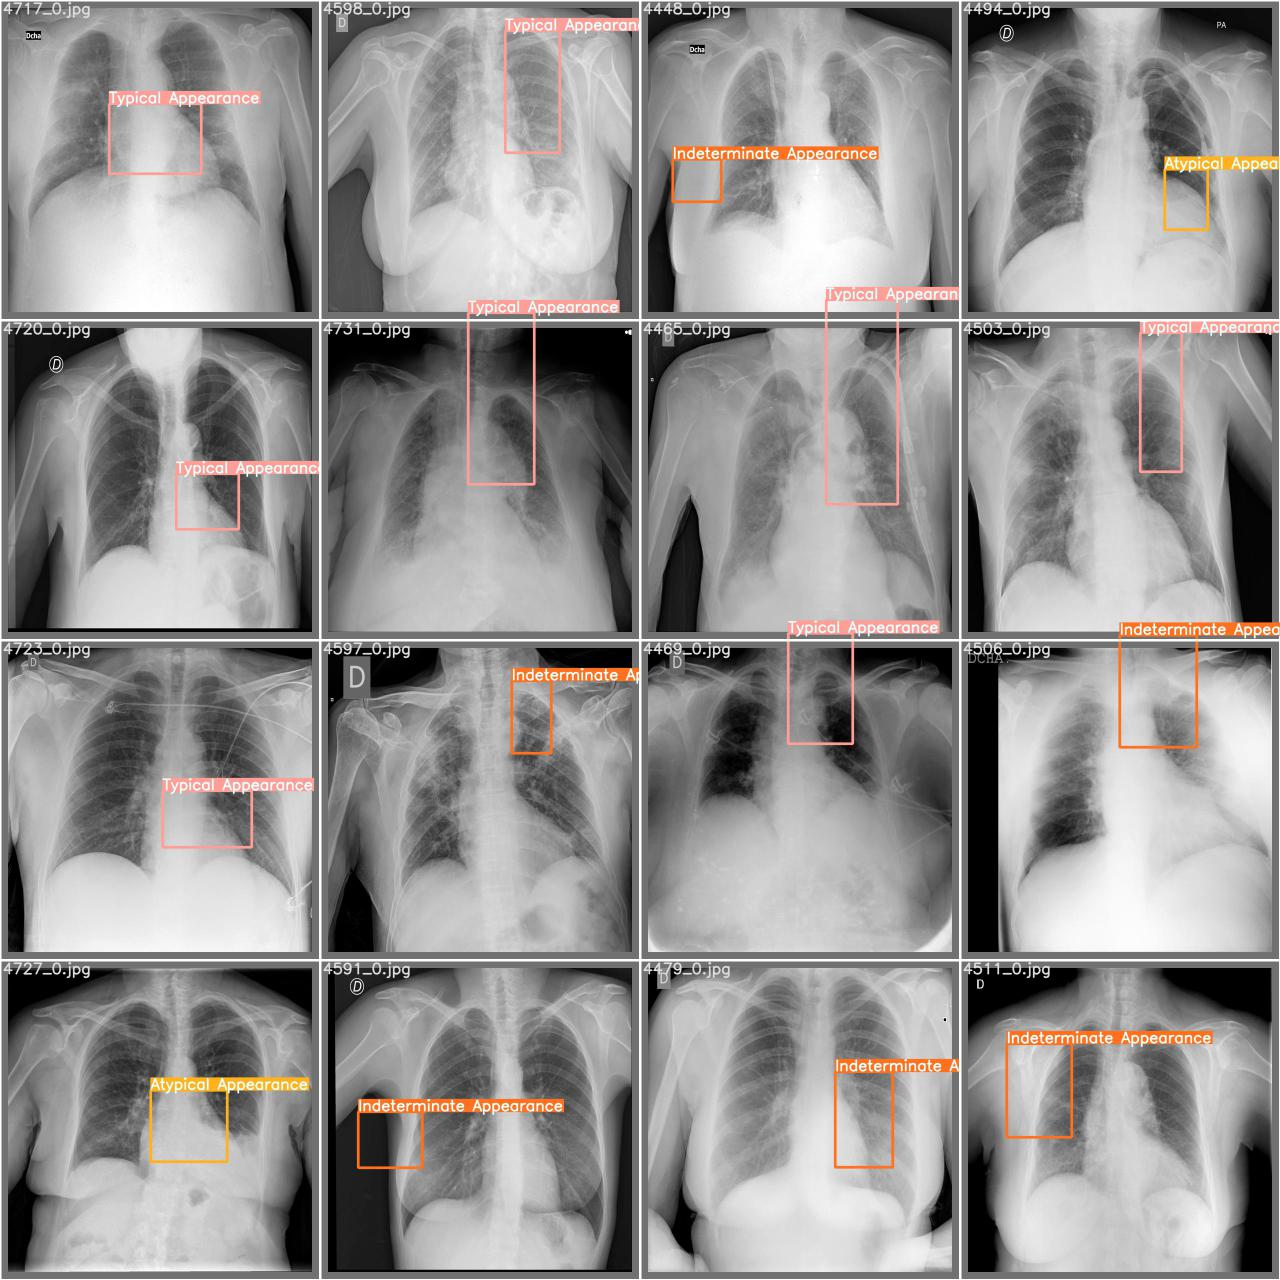

In [18]:
Image('./runs/train/experiment2/test_batch1_labels.jpg')

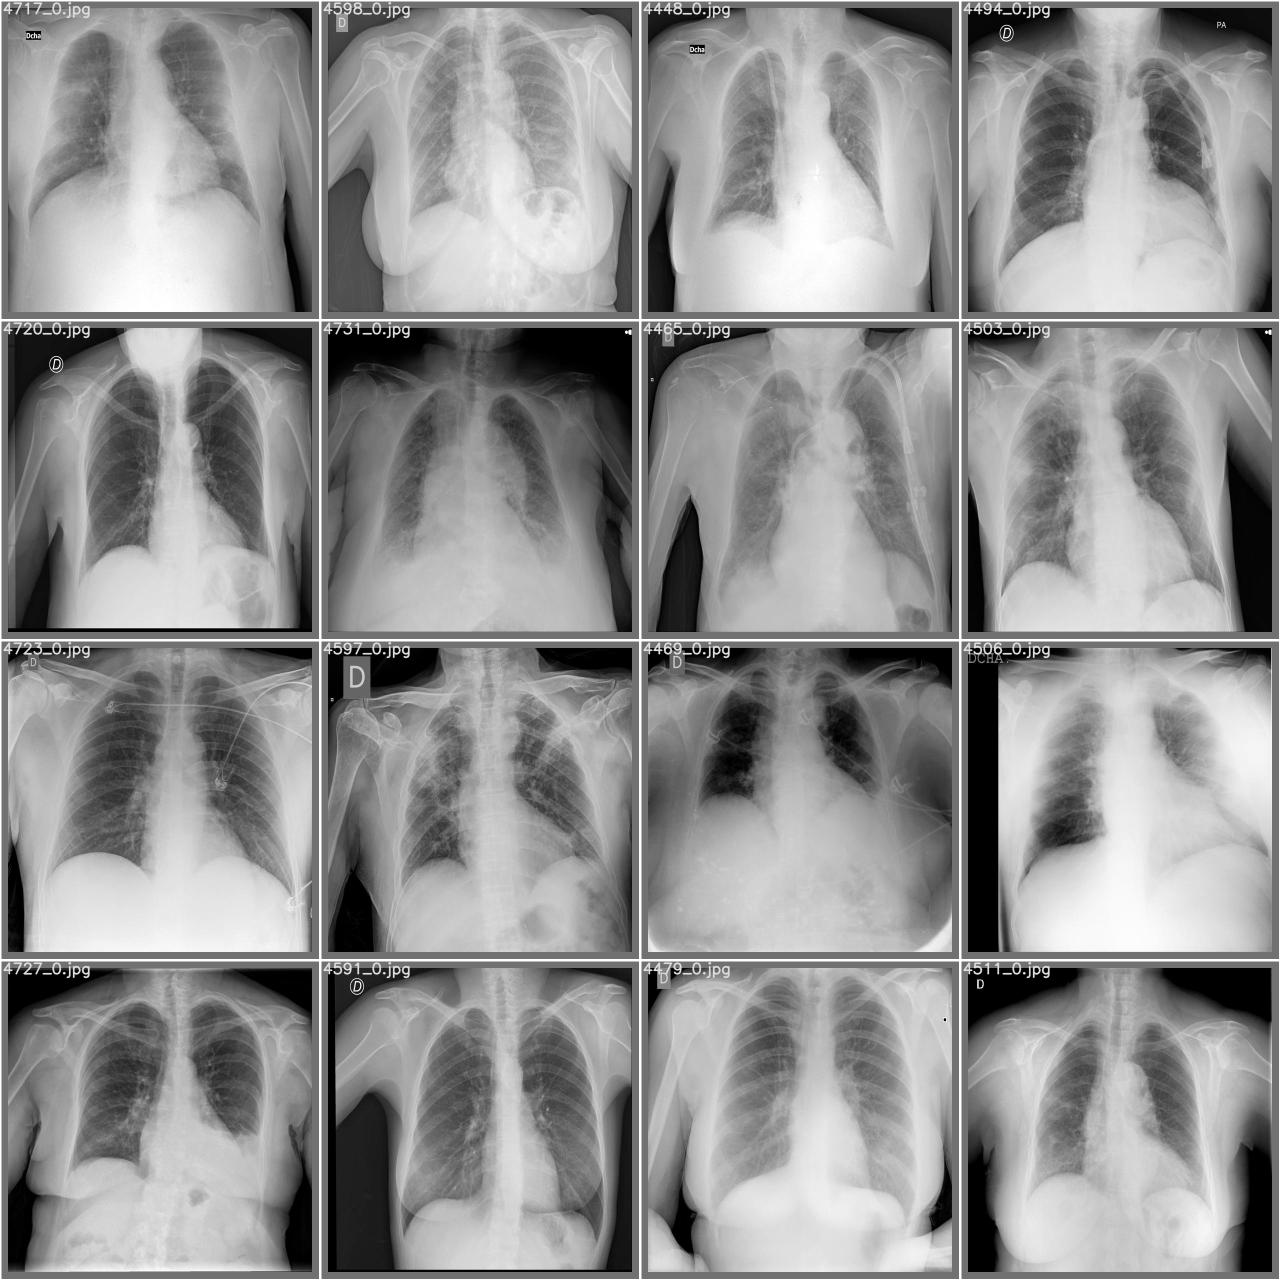

In [19]:
Image('./runs/train/experiment2/test_batch1_pred.jpg')

In [20]:
os.listdir('./Dataset/Covid19')

['labels',
 'images',
 'autosplit_val.txt',
 'autosplit_train.cache',
 'autosplit_val.cache',
 'autosplit_train.txt']

# Detecting the classes 

In [21]:
!python detect.py --img-size 602  --conf 0.1 --source ../input/covid19-detection-for-yolov5-siimfisabiorsna/Covid19/images/1000_0.jpg --weights ./runs/train/experiment2/weights/best.pt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=602, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='../input/covid19-detection-for-yolov5-siimfisabiorsna/Covid19/images/1000_0.jpg', update=False, view_img=False, weights=['./runs/train/experiment2/weights/best.pt'])
image 1/1 /kaggle/working/../input/covid19-detection-for-yolov5-siimfisabiorsna/Covid19/images/1000_0.jpg: 608x608 2 Typical Appearances, Done. (0.063s)
Results saved to runs/detect/exp
Done. (0.101s)


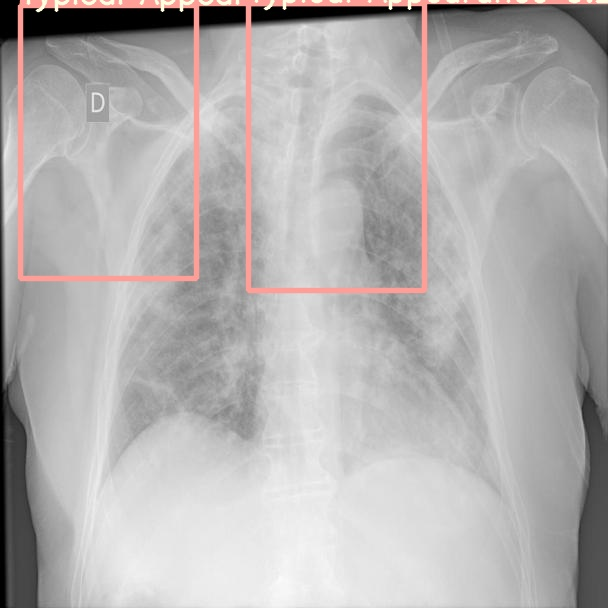

In [22]:
Image('./runs/detect/exp/1000_0.jpg')